In [1]:
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix 
from scipy import stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import statsmodels.api as sm
import matplotlib.pyplot as plt
width, height = 8, 8

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Preprocess policy file
1. Add Last seen date (i.e Cancel date or the date at the end of the obersvation period)
2. Date time conversions
3. Calculate LOS "Length of Stay"
4. Convert all the enrollment dates to zero and based on this calculate the number of months to the last seen date (i.e which is same as the length of stay) and round it of to the nearest integer

In [2]:
# read data
claim_df =  pd.read_csv("./data/ClaimLevel.csv")
policy_df = pd.read_csv("./data/PolicyLevel.csv")

# Last seen Date: CancelDate if not null else '2016-12-31' (Last date in the data set)
policy_df['LastSeenDate'] = policy_df['CancelDate']
policy_df['LastSeenDate'].fillna(pd.to_datetime('2016-12-31'), inplace=True)

# Date conversions
policy_df['EnrollDate'] = pd.to_datetime(policy_df['EnrollDate'])
policy_df['CancelDate'] = pd.to_datetime(policy_df['CancelDate'])
policy_df['LastSeenDate'] = pd.to_datetime(policy_df['LastSeenDate'])

# Length of Stay "LOS"
policy_df['LOS'] = ((policy_df['LastSeenDate'] - policy_df['EnrollDate'])/np.timedelta64(1, 'M'))
policy_df['LOS'] = policy_df['LOS'].astype('int')

# Insurance Status: Active means 0 else 1
policy_df['InsuranceStatus'] = policy_df['CancelDate'].apply(lambda x: 1 if pd.notnull(x) else 0)

# drop null values
policy_df.dropna(axis='index', subset=['MonthlyPremium'], inplace=True)

# display(claim_df.head())
display(policy_df.head(6))

,PolicyId,EnrollDate,CancelDate,MonthlyPremium,LastSeenDate,LOS,InsuranceStatus
0,92597,2010-12-07,NaT,34.54,2016-12-31,72,0
1,92808,2010-11-09,NaT,18.54,2016-12-31,73,0
2,93090,2010-11-11,NaT,23.53,2016-12-31,73,0
3,93122,2010-11-11,NaT,44.02,2016-12-31,73,0
4,93133,2010-11-11,NaT,32.46,2016-12-31,73,0
5,93258,2010-11-11,2016-05-24,21.66,2016-05-24,66,1


In [3]:
"""
                        # Data Preparation & Feature generation#
Generate a single record per policy that retains max information possible
"""
claim_df['CustomerPaidAmount'] = claim_df['ClaimedAmount'] - claim_df['PaidAmount']
claim_df_grouped = claim_df.groupby(['PolicyId'])
claim_per_policy_df = claim_df_grouped[['ClaimedAmount', 'PaidAmount', 'CustomerPaidAmount']].sum()
claim_per_policy_df['ClaimsCount'] = claim_df_grouped.size()
claim_per_policy_df['AvgClaimAmount'] = claim_df_grouped[['ClaimedAmount']].mean()
claim_per_policy_df['AvgPaidAmount'] = claim_df_grouped[['PaidAmount']].mean()
claim_per_policy_df['AvgCustomerPaidAmount'] = claim_df_grouped[['CustomerPaidAmount']].mean()
claim_per_policy_df['stdClaimAmount'] = claim_df_grouped[['ClaimedAmount']].std()
claim_per_policy_df['stdPaidAmount'] = claim_df_grouped[['PaidAmount']].std()
claim_per_policy_df['stdCustomerPaidAmount'] = claim_df_grouped[['CustomerPaidAmount']].std()
claim_per_policy_df['VarianceClaimAmount'] = claim_df_grouped[['ClaimedAmount']].var()
claim_per_policy_df['VariancePaidAmount'] = claim_df_grouped[['PaidAmount']].var()
claim_per_policy_df['VarianceCustomerPaidAmount'] = claim_df_grouped[['CustomerPaidAmount']].var()
claim_per_policy_df['maxClaimAmount'] = claim_df_grouped[['ClaimedAmount']].max()
claim_per_policy_df['minClaimAmount'] = claim_df_grouped[['ClaimedAmount']].min()
claim_per_policy_df['medianClaimAmount'] = claim_df_grouped[['ClaimedAmount']].median()
claim_per_policy_df['maxCustomerPaidAmount'] = claim_df_grouped[['ClaimedAmount']].max()
claim_per_policy_df['minCustomerPaidAmount'] = claim_df_grouped[['ClaimedAmount']].min()
claim_per_policy_df['medianCustomerPaidAmount'] = claim_df_grouped[['ClaimedAmount']].median()

policy_df = policy_df.join(claim_per_policy_df, on=['PolicyId'])

# If no claims were made then all amounts are equal to 0 instead of NULL
for column in list(set(policy_df.columns) - set(['CancelDate'])):
    policy_df[column].fillna(0, inplace=True)

display(policy_df.head(6))

,PolicyId,EnrollDate,CancelDate,MonthlyPremium,LastSeenDate,LOS,InsuranceStatus,ClaimedAmount,PaidAmount,CustomerPaidAmount,...,stdCustomerPaidAmount,VarianceClaimAmount,VariancePaidAmount,VarianceCustomerPaidAmount,maxClaimAmount,minClaimAmount,medianClaimAmount,maxCustomerPaidAmount,minCustomerPaidAmount,medianCustomerPaidAmount
0,92597,2010-12-07,NaT,34.54,2016-12-31,72,0,0.00,0.00,0.00,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
1,92808,2010-11-09,NaT,18.54,2016-12-31,73,0,0.00,0.00,0.00,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
2,93090,2010-11-11,NaT,23.53,2016-12-31,73,0,762.49,329.46,433.03,...,89.285578,49949.935233,18773.2012,7971.914433,510.48,100.00,152.01,510.48,100.00,152.01
3,93122,2010-11-11,NaT,44.02,2016-12-31,73,0,0.00,0.00,0.00,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
4,93133,2010-11-11,NaT,32.46,2016-12-31,73,0,0.00,0.00,0.00,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
5,93258,2010-11-11,2016-05-24,21.66,2016-05-24,66,1,33.99,30.60,3.39,...,0.000000,0.000000,0.0000,0.000000,11.33,11.33,11.33,11.33,11.33,11.33


## SURVIVAL AND HAZARD
Survival data are generally described and modelled in terms of two related probabilities, namely survival and hazard. The survival probability (which is also called the survivor function) S(t) is the probability that an individual survives from the time origin (e.g. diagnosis of cancer) to a specified future time t. It is fundamental to a survival analysis because survival probabilities for different values of t provide crucial summary information from time to event data. These values describe directly the survival experience of a study cohort.

The hazard is usually denoted by h(t) or λ(t) and is the probability that an individual who is under observation at a time t has an event at that time. Put another way, it represents the instantaneous event rate for an individual who has already survived to time t. Note that, in contrast to the survivor function, which focuses on not having an event, the hazard function focuses on the event occurring. It is of interest because it provides insight into the conditional failure rates and provides a vehicle for specifying a survival model. In summary, the hazard relates to the incident (current) event rate, while survival reflects the cumulative non-occurrence.


### KAPLAN–MEIER SURVIVAL ESTIMATE
$S(t_{j}) = S(t_{j-1})(1 - \frac{d_{j}}{n_{j}})$

Suppose that k policies have been lost in the period of follow up (year 2016) at distinct times (each month) $t_{1}<t_{2}<t_{3}<t_{4}<....<t_{k} $ where each $t_{j}$ represents  a month
As events are assumed to occur independently of one another the probabilites of a policies surviving from one interval to the next may be multiplied together to give the cummulative survival probability. 
The probability of a policy being alive at time $t_{j}, S(t_{j})$ is calculated from $S(t_{j-1})$ fromt he probability of being alive at time $t_{j-1}, n_{j}$ the number of patients alive just before $t_{j}$, and $d_{j}$ the number of events at $t_{j}$

$t_{0}=0 \\ S(0)=1$

The value $S(t)$ is constant between times of events and therfore the estimated probability is a step function that changes value only at the time of each event. This estimator allows each patient to contribute information to the calculations for as long as they are known to be event-free. Were every individual to experience the event (i.e. no censoring), this estimator would simply reduce to the ratio of the number of individuals events free at time t divided by the number of people who entered the study.

In [4]:
time = [i for i in range(13)]
count_of_policies_expired_at_time_t = [0,]
count_of_surviving_polcies_before_time_t = []
prob_of_policy_being_alive_at_time_t = [1,]
dates = []

base_date = policy_df['CancelDate'].min() - np.timedelta64(1, 'D')

for t in time:
    date = base_date + np.timedelta64(t, 'M')
    dates.append(date)
    count_of_surviving_polcies_before_time_t.append(len(policy_df[policy_df['LastSeenDate'] > date]))
    if t != 0:
        count_of_policies_expired_at_time_t.append(
            len(policy_df[policy_df['LastSeenDate'] < date] - count_of_policies_expired_at_time_t[t-1]))
        prob_of_policy_being_alive_at_time_t.append(round(prob_of_policy_being_alive_at_time_t[t-1] * (
            1 - (count_of_policies_expired_at_time_t[t]/count_of_surviving_polcies_before_time_t[t-1])), 2))
# print(dates)
# print(count_of_policy_expired_at_time_t)
# print(count_of_surviving_polcies_before_time_t)
print(prob_of_policy_being_alive_at_time_t)

[1, 0.99, 0.97, 0.94, 0.9, 0.85, 0.8, 0.74, 0.67, 0.6, 0.53, 0.46, 0.39]


## cummulative count of policies expired before each month in year 2016

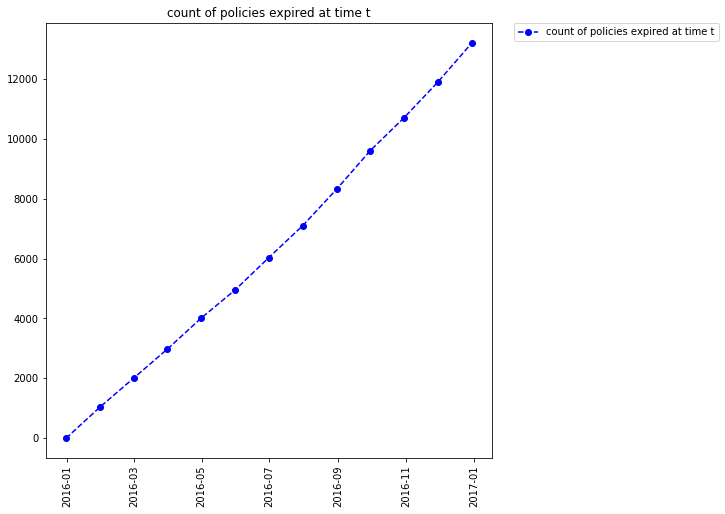

In [5]:
plt.figure(figsize=(width, height))
plt.plot(dates, count_of_policies_expired_at_time_t, linestyle='--', marker='o', color='b',
         label="count of policies expired at time t")
plt.title("count of policies expired at time t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## KAPLAN–MEIER SURVIVAL ESTIMATE

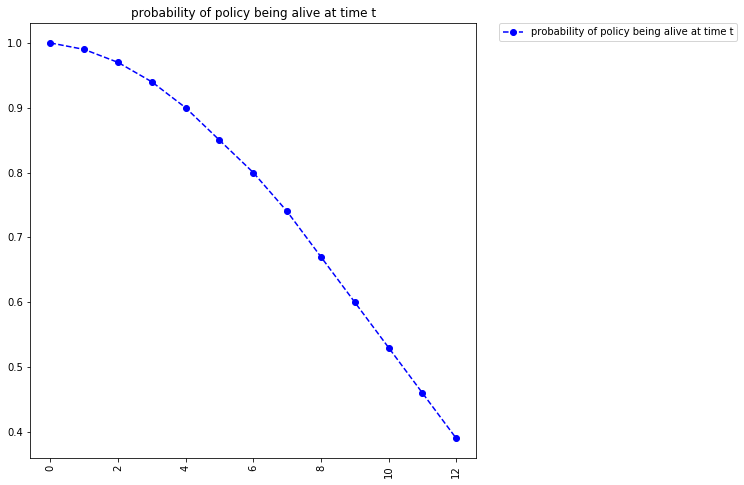

In [6]:
plt.figure(figsize=(width, height))
plt.plot(range(13), prob_of_policy_being_alive_at_time_t, linestyle='--', marker='o', color='b', 
         label="probability of policy being alive at time t")
plt.title("probability of policy being alive at time t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## HAZARD AND CUMULATIVE HAZARD

There is a clearly defined relationship between S(t) and h(t), which is given by the calculus formula:

$h(t) = - \frac{d}{dt}[log(S(t))]$

The point here is simply that if either S(t) or h(t) is known, the other is automatically determined. Consequently, either can be the basis of statistical analysis.
Unfortunately, unlike S(t) there is no simple way to estimate h(t). Instead, a quantity called the cumulative hazard H(t) is commonly used. This is defined as the integral of the hazard, or the area under the hazard function between times 0 and t, and differs from the log-survivor curve only by sign, that is $H(t)=−log[S(t)]$. The interpretation of H(t) is difficult, but perhaps the easiest way to think of H(t) is as the cumulative force of mortality, or the number of events that would be expected for each individual by time t if the event were a repeatable process. H(t) is used an intermediary measure for estimating h(t) and as a diagnostic tool in assessing model validity.

In [7]:
hazard_prob_of_policy_at_time_t = [round(-math.log(x), 2) for x in prob_of_policy_being_alive_at_time_t]
print(hazard_prob_of_policy_at_time_t)

[-0.0, 0.01, 0.03, 0.06, 0.11, 0.16, 0.22, 0.3, 0.4, 0.51, 0.63, 0.78, 0.94]


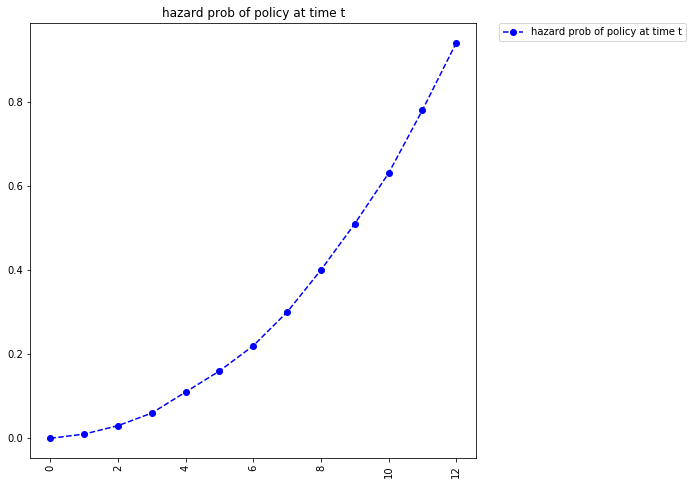

In [8]:
plt.figure(figsize=(width, height))
plt.plot(range(13), hazard_prob_of_policy_at_time_t, linestyle='--', marker='o', color='b', 
         label="hazard prob of policy at time t")
plt.title("hazard prob of policy at time t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## Multivariate data analysis – Choice of Covariates "Cox Proportional Hazards Model"
(Covariates that are fixed and don't change with time)

https://en.wikipedia.org/wiki/Proportional_hazards_model

### feature engineering

Since we have some information about the claims the policy holders have made during the year 2016 we can also incude that information in the semi-parameteric cox model which is show below.

Note: I have included only relevant features after based on P-values from several different combinations. There are much better ways to to do this parameter tuning but I am going forward this naive approach for the purpose of this assignment.

In [9]:
from lifelines import CoxPHFitter

policy_df = policy_df.set_index(keys=['PolicyId'])

X = policy_df[list(set(policy_df.columns) - set(['EnrollDate', 'CancelDate', 'LastSeenDate',
#                                                  'ClaimedAmount', 
                                                 'PaidAmount',
                                                 'CustomerPaidAmount', 
#                                                  'ClaimsCount', 
                                                 'AvgClaimAmount',
#                                                  'AvgPaidAmount',
                                                 'AvgCustomerPaidAmount',
                                                 'stdClaimAmount',
#                                                  'stdPaidAmount',
                                                 'stdCustomerPaidAmount',
                                                 'VarianceClaimAmount', 
                                                 'VariancePaidAmount',
                                                 'VarianceCustomerPaidAmount', 
                                                 'maxClaimAmount',
                                                 'minClaimAmount',
                                                 'medianClaimAmount', 
                                                 'maxCustomerPaidAmount',
                                                 'minCustomerPaidAmount', 
                                                 'medianCustomerPaidAmount'
                                                ]))]
cph = CoxPHFitter()
cph.fit(X, duration_col='LOS', event_col='InsuranceStatus')

cph.print_summary()

n=99995, number of events=13215

                  coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
ClaimedAmount   0.0003     1.0003    0.0000  15.1958 0.0000      0.0002      0.0003  ***
AvgPaidAmount  -0.0004     0.9996    0.0001  -4.6846 0.0000     -0.0006     -0.0002  ***
stdPaidAmount  -0.0008     0.9992    0.0001  -7.0660 0.0000     -0.0011     -0.0006  ***
ClaimsCount    -0.0611     0.9407    0.0037 -16.5024 0.0000     -0.0684     -0.0539  ***
MonthlyPremium -0.0090     0.9910    0.0007 -12.5776 0.0000     -0.0105     -0.0076  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.574


### Translating the output to Jan 2017 for each policy

But since we have changed the time from calender time to survival time format to run the survival analysis we know have convert the time back to calendar time for each policy.

Since we have the "LOS" parameter which gives us the month the policy is last seen we can now go head and add 1 to the "LOS" variable and extract the hazard probability at event "LOS + 1" for each policy.

What we are predicting below are probability that a policies survives in Jan 2017.

In [43]:
X_test = X.drop(['InsuranceStatus'], axis=1)
X_test['LOS'] = X_test['LOS'] + 1
output = cph.predict_survival_function(X=X_test)

In [65]:
indicies = X['LOS'] + 1
indicies = {x:y for x,y in indicies.items()}
survival_porb_jan2017 = {}
# survival_porb_jan2017 = {x:output.loc[y,x] for x,y in indicies.items()}
for x,y in indicies.items():
    try:
        survival_porb_jan2017[x] = (output.loc[y,x])
    except KeyError:
        survival_porb_jan2017[x] = 0
        pass

survival_porb_jan2017_df = pd.DataFrame.from_dict(survival_porb_jan2017, orient='index')
survival_porb_jan2017_df = survival_porb_jan2017_df.join(policy_df[['InsuranceStatus']], how='left')
# survival_porb_jan2017_df[survival_porb_jan2017_df[0] < 0.6]
# survival_porb_jan2017_df[survival_porb_jan2017_df['InsuranceStatus'] == 1]

In [66]:
survival_porb_jan2017_df.reset_index(inplace=True)
survival_porb_jan2017_df.drop(['InsuranceStatus'], inplace=True, axis=1)
survival_porb_jan2017_df.columns = ['PolicyId', 'Prob_not_cancel']
survival_porb_jan2017_df['Prob_cancel'] = 1 - survival_porb_jan2017_df['Prob_not_cancel']
survival_porb_jan2017_df.to_csv('./data/survival_prob_jan2017.csv', index=False)